In [7]:
import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
from numpy.random import randint, random
import scipy.stats
import math
import cv2
import imageio

from sklearn import cluster
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
from scipy import ndimage
%matplotlib inline

# input fllename >> output 3d array
def read_img(filename, mode, size):
    if mode == 'RGB':
        img_3d = imageio.imread(filename)
        #img_3d = cv2.imread(filename)
        #img_3d = cv2.cvtColor(img_3d, cv2.COLOR_BGR2RGB)
    elif mode == 'L':
        img_3d = imageio.imread(filename, mode = 'L')
    # Downsample the image
    #small = cv2.resize(img_3d, (0, 0), fx = size[0], fy = size[1])
    # Blurring effect to denoise
    #blur = cv2.blur(small, (4, 4))

    
    return img_3d


# input 3d array >> output 2d array
def flatten_img(img_3d, mode):
    if mode == 'RGB':
        x, y, z = img_3d.shape
        img_2d = img_3d.reshape(x*y, z)
        img_2d = np.array(img_2d, dtype = np.float)
    elif mode == 'L':
        x, y = img_3d.shape
        img_2d = img_3d.reshape(x*y, 1)
        img_2d = np.array(img_2d, dtype = np.float)
    return img_2d


# input 2d array >> output 3d array
def recover_img(img_2d, X, Y, mode = 'RGB', vis = False):
    #img_2d = cv2.resize(img_2d, (0, 0), fx=10, fy=10)
    if mode == 'RGB':
        img_2d = (img_2d * 255).astype(np.uint8)
        recover_img = img_2d.reshape(X, Y, 3)
    elif mode == 'L':
        recover_img = img_2d.reshape(X, Y)
    return recover_img


# input 2d array >> output estimated means, stds, pis
def kmeans_init(img, k):
    means, labels = kmeans2(img, k)
    try:
        means = np.array(means)
        cov = np.array([np.cov(img[labels == i].T) for i in range(k)])
        ids = set(labels)
        pis = np.array([np.sum([labels == i]) / len(labels) for i in ids])
    except Exception as ex:
        pass
    return means, cov, pis

def random_init(img, k):
    # For gray-scale
    if len(img.shape) == 1:
        means = randint(low = 0, high = 255, size = (k,1))
        cov = randint(low = 0, high = 500, size = k)
        pis = random(size = k)
    else:
        z = img.shape[1]
        means = randint(low = 0, high = 255, size = (k , z))
        pre_cov = randint(low=0, high=2, size=img.shape[0])
        cov = np.array([np.cov(img[pre_cov == i].T) for i in range(k)])
        pis = random(size = k)
    return means, cov, pis


# E-Step: Update Parameters
# update the conditional pdf - prob that pixel i given class j
def update_responsibility(img, means, cov, pis, k):
    # responsibilities: i th pixels, j th class
    # pis * gaussian.pdf
    responsibilities = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j], allow_singular=True) for j in range(k)]).T
    # normalize for each row
    norm = np.sum(responsibilities, axis = 1)
    # convert to column vector
    norm = np.reshape(norm, (len(norm), 1))
    responsibilities = responsibilities / norm
    return responsibilities


# update pi for each class of Gaussian model
def update_pis(responsibilities):
    pis = np.sum(responsibilities, axis = 0) / responsibilities.shape[0]
    return pis

# update means for each class of Gaussian model
def update_means(img, responsibilities):
    means = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        means_j = weight.dot(img)
        means.append(means_j[0])
    means = np.array(means)
    return means

# update covariance matrix for each class of Gaussian model
def update_covariance(img, responsibilities, means):
    cov = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        # Each pixels have a covariance matrice
        covs = [np.mat(i - means[j]).T * np.mat(i - means[j]) for i in img]
        # Weighted sum of covariance matrices
        cov_j = sum(weight[0][i] * covs[i] for i in range(len(weight[0])))
        cov.append(cov_j)
    cov = np.array(cov)
    return cov


# M-step: choose a label that maximise the likelihood
def update_labels(responsibilities):
    labels = np.argmax(responsibilities, axis = 1)
    return labels


def update_loglikelihood(img, means, cov, pis, k):
    pdf = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j], allow_singular=True) for j in range(k)])
    log_ll = np.log(np.sum(pdf, axis = 0))
    log_ll_sum = np.sum(log_ll)
    return log_ll_sum


def EM_cluster(img, k, random = False, error = 10e-4, iter_n = 9999):
    #  init setting
    cnt = 0
    likelihood_arr = []
    means_arr = []
    if not random:
        # Initialise E-Step by KMeans
        means, cov, pis = kmeans_init(img, k)

    else:
        means, cov, pis = random_init(img, k)
    #print(means, cov, pis)
    likelihood = 0
    new_likelihood = 2
    means_arr.append(means)
    responsibilities = update_responsibility(img, means, cov, pis, k)
    while (abs(likelihood - new_likelihood) > error) and (cnt != iter_n):
        start_dt = datetime.datetime.now()
        cnt += 1
        likelihood = new_likelihood
        # M-Step
        labels = update_labels(responsibilities)
        # E-step
        responsibilities = update_responsibility(img, means, cov, pis, k)
        means = update_means(img, responsibilities)
        cov = update_covariance(img, responsibilities, means)
        pis = update_pis(responsibilities)
        new_likelihood = update_loglikelihood(img, means, cov, pis, k)
        likelihood_arr.append(new_likelihood)
        end_dt = datetime.datetime.now()
        diff = relativedelta(end_dt, start_dt)
        print("iter: %s, time interval: %s:%s:%s:%s" % (cnt, diff.hours, diff.minutes, diff.seconds, diff.microseconds))
        print("log-likelihood = {}".format(new_likelihood))
        # Store means stat
        means_arr.append(means)
    likelihood_arr = np.array(likelihood_arr)
    print('Converge at iteration {}'.format(cnt + 1))
    return labels, means, cov, pis, likelihood_arr, means_arr

In [8]:
def get_pdf(y, means, cov, pis, k):
    pdf_arr = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(y, mean=means[j], cov=cov[j], allow_singular=True) for j in range(k)])
    pdf = np.sum(pdf_arr)
    return pdfx

In [9]:
FILENAME_LIST = ['/Users/tony/Desktop/498 hwk/hw5/RobertMixed03.jpg', '/Users/tony/Desktop/498 hwk/hw5/smallstrelitzia.jpg', '/Users/tony/Desktop/498 hwk/hw5/smallsunset.jpg']
#FILENAME_LIST = ['/Users/tony/Desktop/498 hwk/hw5/smallsunset.jpg']

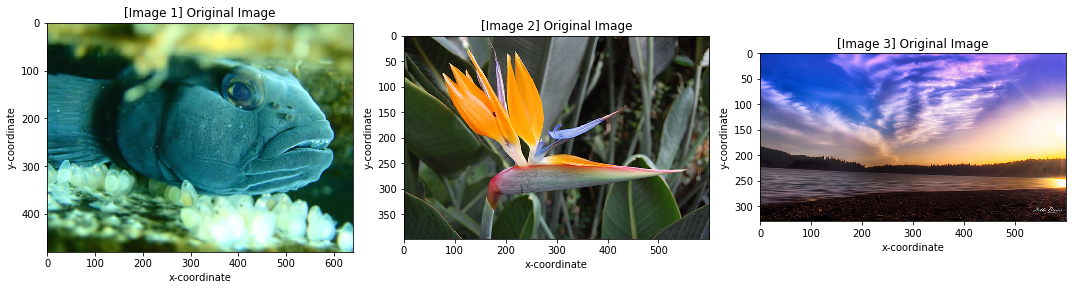

In [13]:
# Visualize demo images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
rgb_img_list = []
dim_img_list = []
i = 1
for filename, ax in zip(FILENAME_LIST, ax_list):
    rgb_img = read_img(filename = filename, mode = 'RGB', size = (0.5, 0.5))
    x, y, z = rgb_img.shape
    # Store dimension for each image
    dim_img_list.append((x,y,z))
    # Store img 
    rgb_img_list.append(rgb_img)
    ax.imshow(rgb_img)
    ax.set_title('[Image {}] Original Image'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1

plt.tight_layout()
fig.savefig('orig_images.pdf')

In [14]:
ax_list

## GET K-MEANS IMAGES - K=2

In [11]:
img_list = [flatten_img(image, mode = 'RGB') for image in rgb_img_list]

In [9]:
# Run and Store KMeans image
from sklearn import cluster
from scipy.cluster.vq import kmeans2
kmeans_img_list = []

for img, dim in zip(img_list, dim_img_list):
    k_means, k_labels = kmeans2(img, 10)
    print(k_labels)
    k_means, k_labels
    kmeans_img = np.array([i[0] for i in k_means[k_labels]])
    kmeans_img = kmeans_img.reshape(dim[0], dim[1])
    kmeans_img_list.append(kmeans_img)


[8 8 8 ... 5 5 5]
[5 5 5 ... 1 1 1]
[8 8 8 ... 9 9 1]


In [10]:
kmeans_img_list

[array([[154.84063965, 154.84063965, 154.84063965, ..., 154.84063965,
         154.84063965, 154.84063965],
        [154.84063965, 154.84063965, 154.84063965, ..., 154.84063965,
         154.84063965, 154.84063965],
        [154.84063965, 154.84063965, 154.84063965, ..., 154.84063965,
         154.84063965, 154.84063965],
        ...,
        [ 13.05005698,  13.05005698,  13.05005698, ..., 132.87471189,
         132.87471189, 132.87471189],
        [ 13.05005698,  13.05005698,  13.05005698, ..., 132.87471189,
         132.87471189, 132.87471189],
        [ 13.05005698,  13.05005698,  13.05005698, ..., 132.87471189,
         132.87471189, 132.87471189]]),
 array([[21.55330319, 21.55330319, 21.55330319, ..., 21.55330319,
         37.2811683 , 37.2811683 ],
        [21.55330319, 21.55330319, 21.55330319, ..., 21.55330319,
         37.2811683 , 37.2811683 ],
        [21.55330319, 21.55330319, 21.55330319, ..., 21.55330319,
         37.2811683 , 37.2811683 ],
        ...,
        [37.281168

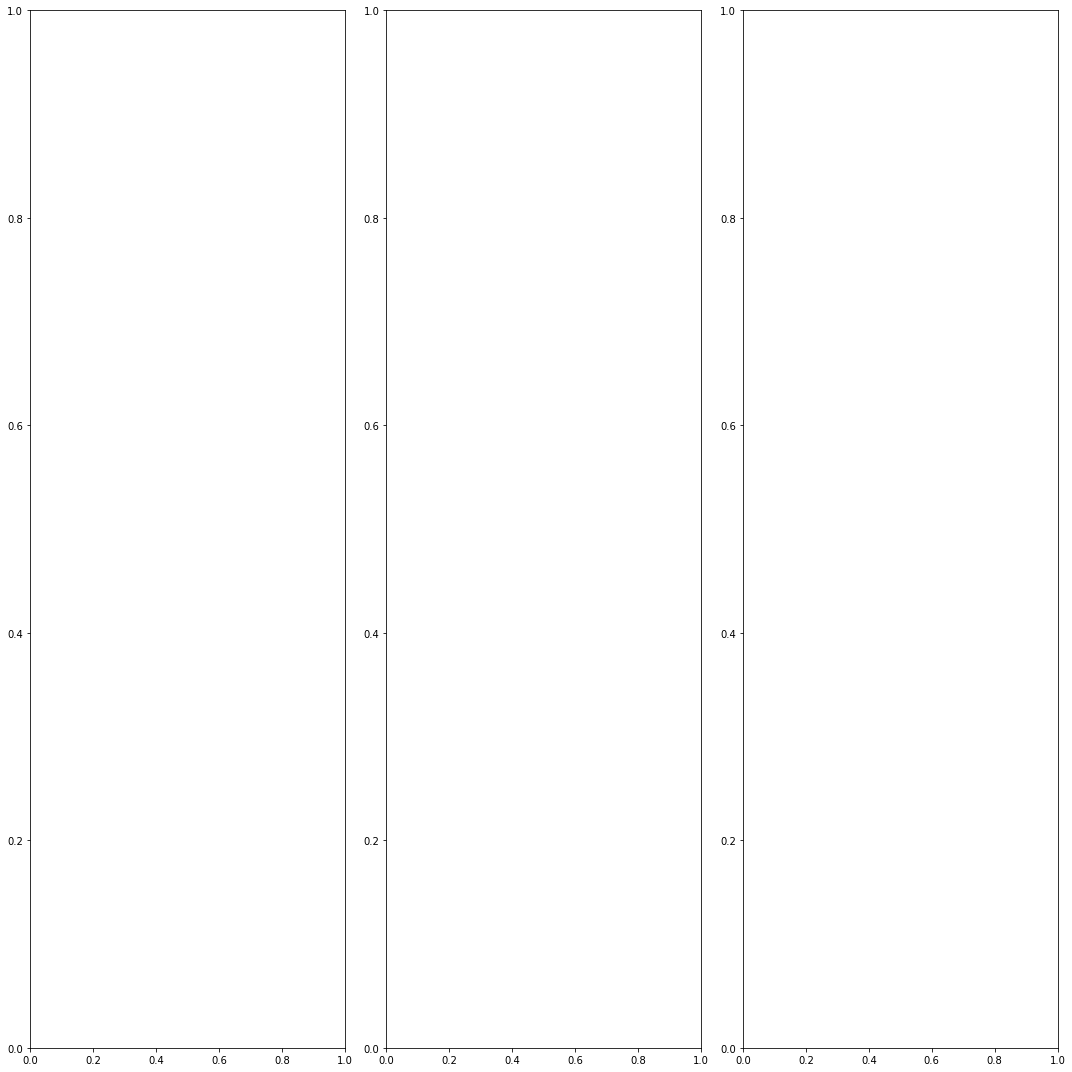

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
i = 1
for kmeans_img, ax, dim in zip(kmeans_img_list, ax_list, dim_img_list):
    ax.imshow(kmeans_img)
    ax.set_title('[Image {}] Segmentation by KMeans'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1
    
plt.tight_layout()
fig.savefig('kmeans_images.pdf')

## GET EM (WITH KMEANS INIT) IMAGES AND STAT - K=2

In [14]:
# Init container
likelihood_arr_list = []
means_arr_list = []
cov_arr_list = []
pis_arr_list = []
em_img_list = []
means_list = []

for img, dim in zip(img_list, dim_img_list):
    labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(img, 20, error = 0.001)
    means = np.array([element[0] for element in means])
    cov = [element[0][0] for element in cov]
    em_img = means[labels]
    recover_img = em_img.reshape(dim[0], dim[1])
    # store required stat
    likelihood_arr_list.append(likelihood_arr)
    means_arr_list.append(means_arr)
    cov_arr_list.append(cov)
    pis_arr_list.append(pis)
    em_img_list.append(recover_img)
    means_list.append(means)

d = -3999425.563606156
iter: 864, time interval: 0:2:53:139855
log-likelihood = -3999413.3802699363
iter: 865, time interval: 0:2:52:940390
log-likelihood = -3999392.5600217716
iter: 866, time interval: 0:2:52:923543
log-likelihood = -3999338.712602167
iter: 867, time interval: 0:2:52:979567
log-likelihood = -3999047.7654213547
iter: 868, time interval: 0:2:53:318225
log-likelihood = -3996553.0228377515
iter: 869, time interval: 0:2:53:248785
log-likelihood = -3997688.788613588
iter: 870, time interval: 0:2:51:982409
log-likelihood = -4000168.4173923563
iter: 871, time interval: 0:2:52:881324
log-likelihood = -3999629.5581458663
iter: 872, time interval: 0:2:52:681816
log-likelihood = -3999524.9662214103
iter: 873, time interval: 0:2:52:947862
log-likelihood = -3999456.519145299
iter: 874, time interval: 0:2:53:343709
log-likelihood = -3999411.93432636
iter: 875, time interval: 0:2:52:693152
log-likelihood = -3999388.7142528384
iter: 876, time interval: 0:2:52:792777
log-likelihood = -

KeyboardInterrupt: 

In [6]:
len(em_img_list[0][0])

NameError: name 'em_img_list' is not defined

In [6]:
# Store density estimate (i.e pdf)
pdf_arr_list = []
for em_img, means, cov, pis in zip(em_img_list, means_list, cov_arr_list, pis_arr_list):
    pdf_arr = [get_pdf(i, means, cov, pis, 2) for i in np.linspace(0, 255, 256)]
    pdf_arr_list.append(pdf_arr)

NameError: name 'em_img_list' is not defined

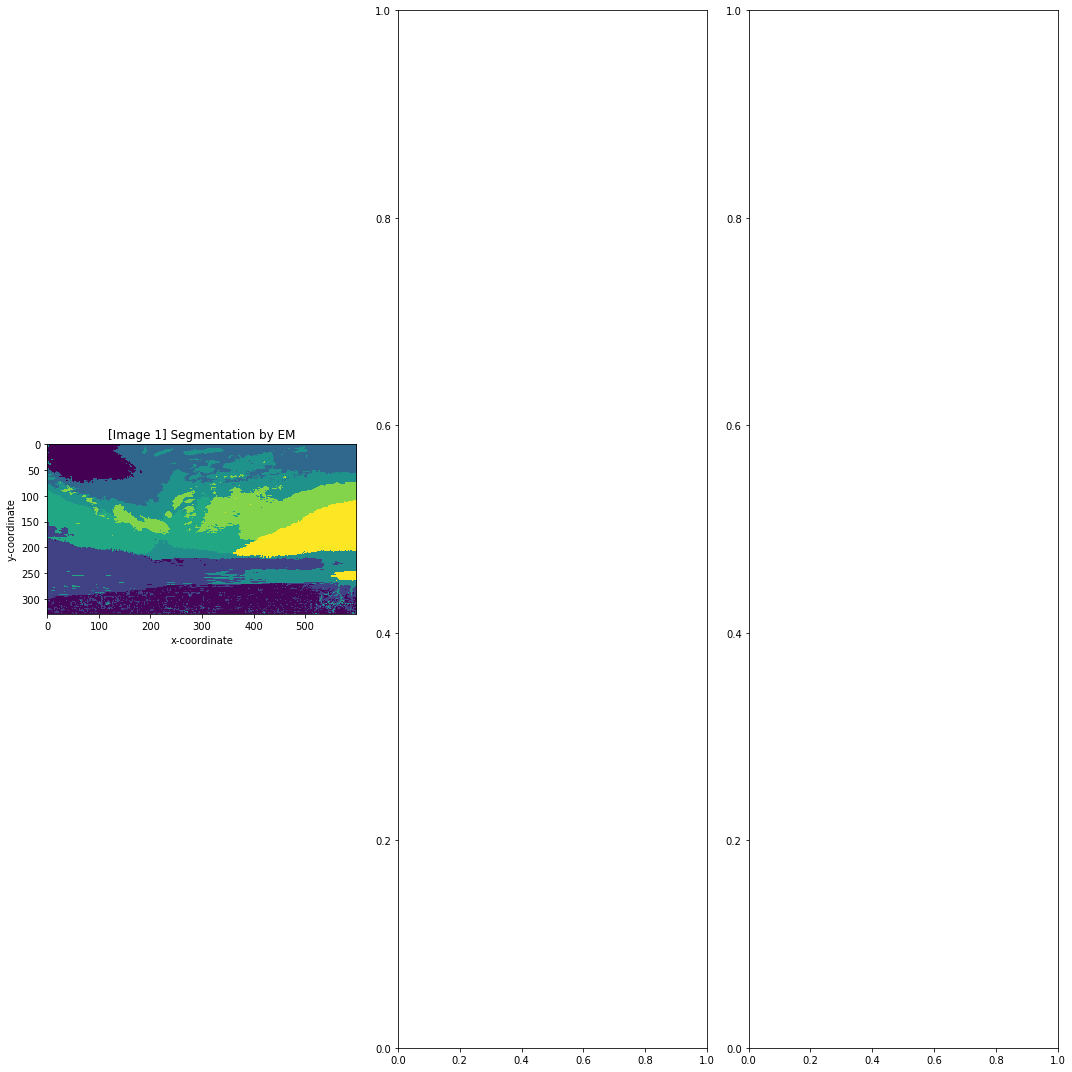

In [17]:
# supposedly the images after replacing kmeans em
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
i = 1
for em_img, ax, dim in zip(em_img_list, ax_list, dim_img_list):
    ax.imshow(em_img)
    ax.set_title('[Image {}] Segmentation by EM'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1
    
plt.tight_layout()
fig.savefig('em_images.pdf')

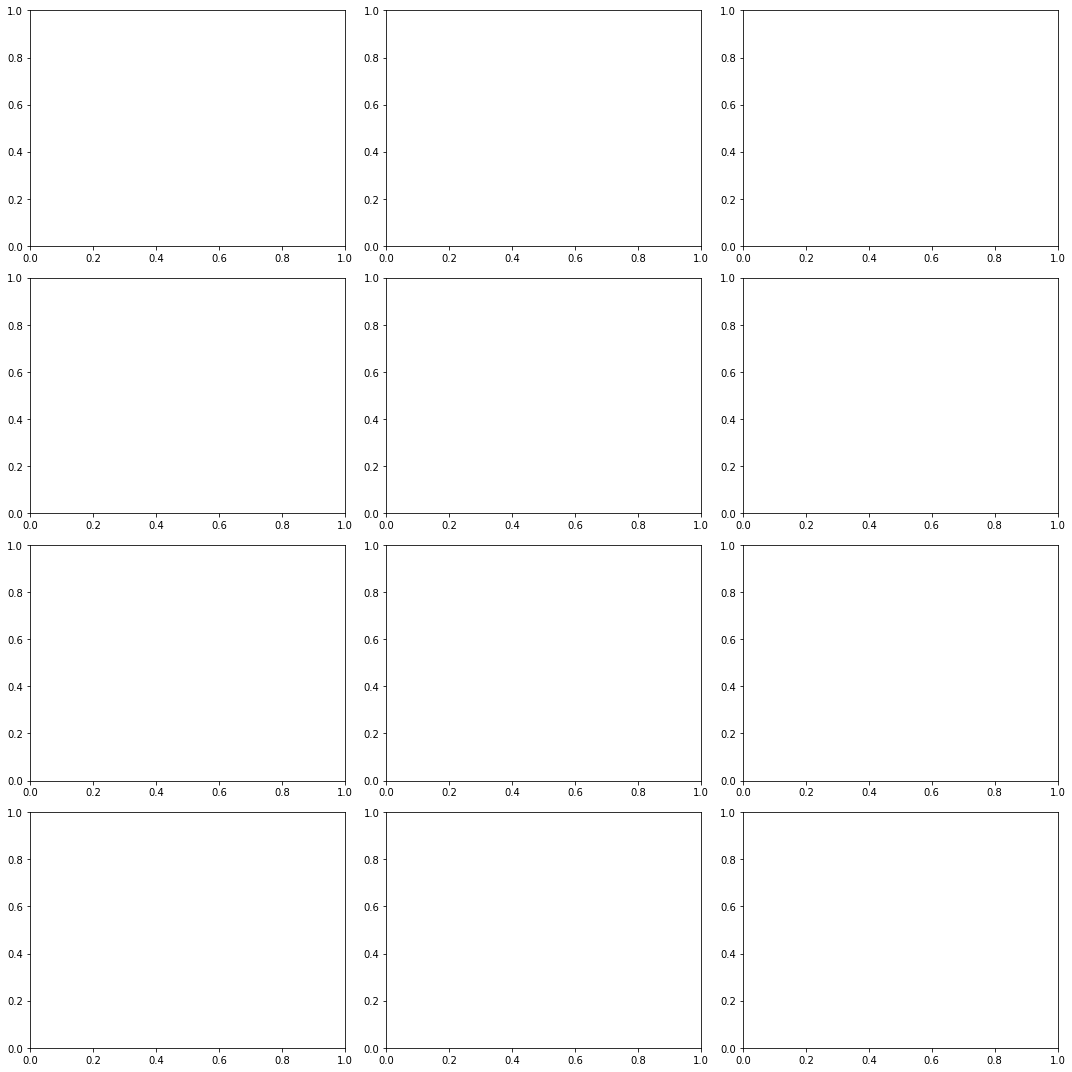

In [27]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
i = 1
# FIRST ROW: display image segment
for em_img, ax in zip(em_img_list, ax_list):
    ax.imshow(em_img)
    ax.set_title('[Image {}] Segmentation by EM'.format(i))
    # Set x-axis, y-axis
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1

# SECOND ROW: display density estimate
ax_list = [ax4, ax5, ax6]
i = 1
for img, pdf, ax in zip(img_list, pdf_arr_list, ax_list):
    ax.hist(img, bins = 30, normed = True, alpha = 0.5, label='Histogram')
    ax.plot(pdf, 'r--', linewidth = 2, label = 'Estimated GMM')
    ax.set_title('[Image {}] Density Estimate of Intensity'.format(i))
    ax.legend()
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Intensity')
    ax.axes.set_ylabel('Probability')
    # Strink the y-axis
    ax.set_ylim(0, 0.06)    
    i += 1
    
# THIRD ROW: density estimate
ax_list = [ax7, ax8, ax9]
i = 1
for ll, ax in zip(likelihood_arr_list, ax_list):
    ax.plot(ll, 'g-')
    ax.set_title('[Image {}] Likelihood Estimate over Iterations'.format(i))
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Iterations')
    ax.axes.set_ylabel('Likelihood Estimate')
    i += 1

# FOURTH ROW: displays means evolution over iteration
ax_list = [ax10, ax11, ax12]
i = 1
for m, ax in zip(means_arr_list, ax_list):
    # The 2nd image has class label inversed
    if i == 2:
        # Remove inner index
        m1 = [i[1][0] for i in m]
        m2 = [i[0][0] for i in m]
    else:       
        m1 = [i[0][0] for i in m]
        m2 = [i[1][0] for i in m]
    ax.plot(m1, 'r--', label = 'Class 1')
    ax.plot(m2, 'b-', label = 'Class 2')
    ax.set_title('[Image {}] Mean Evolution for each Class'.format(i))
    ax.legend(loc = 4)
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Iterations')
    ax.axes.set_ylabel('Mean Estimate')
    i += 1

# Make a nice layout
plt.tight_layout()
plt.savefig("em_kmeans_init.pdf")

## GET EM (WITH RANDOM INIT) IMAGES AND STAT - K=2

In [7]:
img_list

[array([[155., 189.,  99.],
        [155., 189.,  99.],
        [154., 188.,  98.],
        ...,
        [132., 213., 217.],
        [117., 196., 209.],
        [109., 187., 204.]]),
 array([[24., 25., 19.],
        [24., 25., 19.],
        [24., 25., 19.],
        ...,
        [50., 56., 61.],
        [48., 53., 56.],
        [45., 50., 53.]]),
 array([[ 16.,  58., 177.],
        [ 16.,  58., 177.],
        [ 15.,  58., 178.],
        ...,
        [ 52.,  30.,  26.],
        [ 49.,  28.,  27.],
        [ 45.,  26.,  25.]])]

In [20]:
# Init container
rand_likelihood_arr_list = []
rand_means_arr_list = []
rand_cov_arr_list = []
rand_pis_arr_list = []
rand_em_img_list = []
rand_means_list = []

for img, dim in zip(img_list, dim_img_list):
    labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(img, 10, random = True, error = 0.001)
    means = np.array([element[0] for element in means])
    cov = [element[0][0] for element in cov]
    em_img = means[labels]
    recover_img = em_img.reshape(dim[0], dim[1])
    # store required stat
    rand_likelihood_arr_list.append(likelihood_arr)
    rand_means_arr_list.append(means_arr)
    rand_cov_arr_list.append(cov)
    rand_pis_arr_list.append(pis)
    rand_em_img_list.append(recover_img)
    rand_means_list.append(means)

ValueError: array must not contain infs or NaNs

In [15]:
# Store density estimate (i.e pdf)
rand_pdf_arr_list = []
for em_img, means, cov, pis in zip(rand_em_img_list, rand_means_list, rand_cov_arr_list, rand_pis_arr_list):
    rand_pdf_arr = [get_pdf(i, means, cov, pis, 2) for i in np.linspace(0, 255, 256)]
    rand_pdf_arr_list.append(rand_pdf_arr)

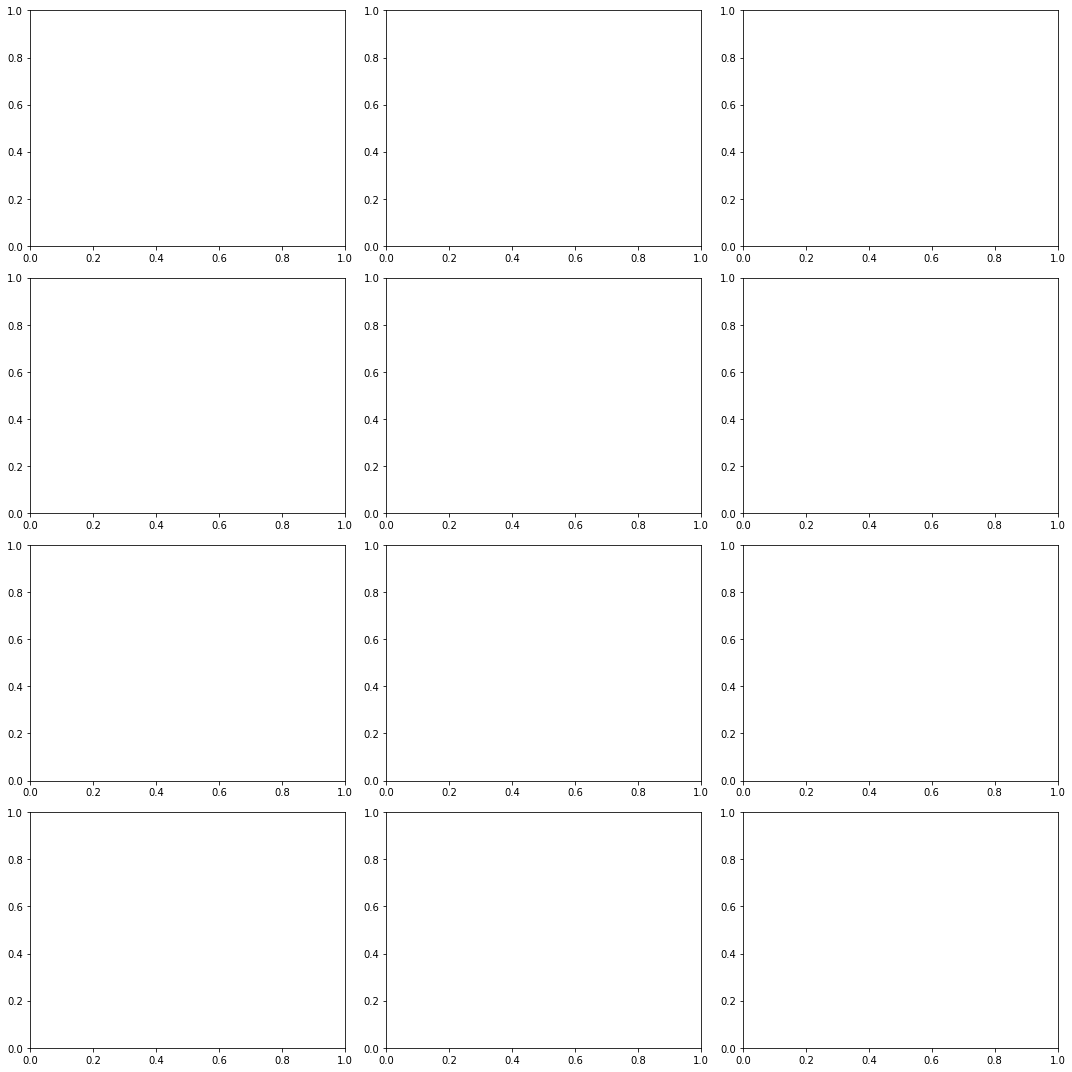

In [15]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)) = plt.subplots(4, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
i = 1
# FIRST ROW: display image segment
for rand_em_img, ax in zip(rand_em_img_list, ax_list):
    ax.imshow(rand_em_img)
    ax.set_title('[Image {}] Segmentation by EM'.format(i))
    # Set x-axis, y-axis
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1;

# SECOND ROW: display density estimate
ax_list = [ax4, ax5, ax6]
i = 1
for img, pdf, ax in zip(img_list, rand_pdf_arr_list, ax_list):
    ax.hist(img, bins = 30, normed = True, alpha = 0.5, label='Histogram')
    ax.plot(pdf, 'r--', linewidth = 2, label = 'Estimated GMM')
    ax.set_title('[Image {}] Density Estimate of Intensity'.format(i))
    ax.legend()
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Intensity')
    ax.axes.set_ylabel('Probability')
    # Strink the y-axis
    ax.set_ylim(0, 0.06)    
    i += 1;
    
# THIRD ROW: loglikelihood estimate
ax_list = [ax7, ax8, ax9]
i = 1
for ll, ax in zip(rand_likelihood_arr_list, ax_list):
    ax.plot(ll, 'g-')
    ax.set_title('[Image {}] Likelihood Estimate over Iterations'.format(i))
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Iterations')
    ax.axes.set_ylabel('Loglikelihood Estimate')
    i += 1

# FOURTH ROW: displays means evolution over iteration
ax_list = [ax10, ax11, ax12]
i = 1
for m, ax in zip(rand_means_arr_list, ax_list):
    # The 1st image has class label inversed
    if i == 1:
        # Remove inner index
        m1 = [i[1][0] for i in m]
        m2 = [i[0][0] for i in m]
    else:       
        m1 = [i[0][0] for i in m]
        m2 = [i[1][0] for i in m]
    ax.plot(m1, 'r--', label = 'Class 1')
    ax.plot(m2, 'b-', label = 'Class 2')
    ax.set_title('[Image {}] Mean Evolution for each Class'.format(i))
    ax.legend(loc = 4)
    # Set x-axis, y-axis
    ax.axes.set_xlabel('Iterations')
    ax.axes.set_ylabel('Mean Estimate')
    i += 1

# Make a nice layout
plt.tight_layout();
fig.savefig('em_rand_init.pdf')

## ADD NOISE DEMO

In [18]:
import numpy as np
import random
import cv2

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

image = read_img('./img/hybrid.jpg', mode = 'RGB', size = (0.6, 0.6)) 
noise_img = sp_noise(image,0.1)
x, y, z = noise_img.shape

FileNotFoundError: No such file: '/Users/tony/Desktop/498 hwk/hw5/img/hybrid.jpg'

In [19]:
plt.imshow(noise_img);

NameError: name 'noise_img' is not defined

In [20]:
flat_img =  flatten_img(noise_img, mode = 'RGB')
labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(flat_img, 10, error = 0.001)
means = np.array([element[0] for element in means])
cov = [element[0][0] for element in cov]
em_img = means[labels]
recover_img_1 = em_img.reshape(x, y)
plt.imshow(recover_img_1);

NameError: name 'noise_img' is not defined

In [21]:
blur_img = cv2.blur(noise_img, (4, 4))
plt.imshow(blur_img);

NameError: name 'noise_img' is not defined

In [22]:
flat_img =  flatten_img(blur_img, mode = 'RGB')
labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(flat_img, 2, error = 0.001)
means = np.array([element[0] for element in means])
cov = [element[0][0] for element in cov]
em_img = means[labels]
recover_img_2 = em_img.reshape(x, y)
plt.imshow(recover_img_2);

NameError: name 'blur_img' is not defined

In [23]:
recover_img = em_img.reshape(x, y)
plt.imshow(recover_img);

NameError: name 'em_img' is not defined

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (10,10))

ax1.imshow(noise_img)
ax1.set_title('Original Image Before De-noise')

ax2.imshow(blur_img)
ax2.set_title('Original Image After De-noise ')

ax3.imshow(recover_img_1)
ax3.set_title('EM Segmentation Before De-noise ')

ax4.imshow(recover_img_2)
ax4.set_title('EM Segmentation After De-noise ')

ax1.axes.set_xlabel('x-coordinate')
ax1.axes.set_ylabel('y-coordinate')

# SECOND ROW: log-likelihood evolution

plt.tight_layout()
fig.savefig('denoise_compare.pdf')

NameError: name 'noise_img' is not defined

In [25]:
iter_num = [1, 10, 25]
demo_img_list = []
for n in iter_num:
    labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(flat_img, 2, error = 0.001, iter_n = n)
    cov = [element[0][0] for element in cov]
    em_img = means[labels]
    tmp_img = em_img.reshape(x, y,z)
    demo_img_list.append(tmp_img)

NameError: name 'flat_img' is not defined

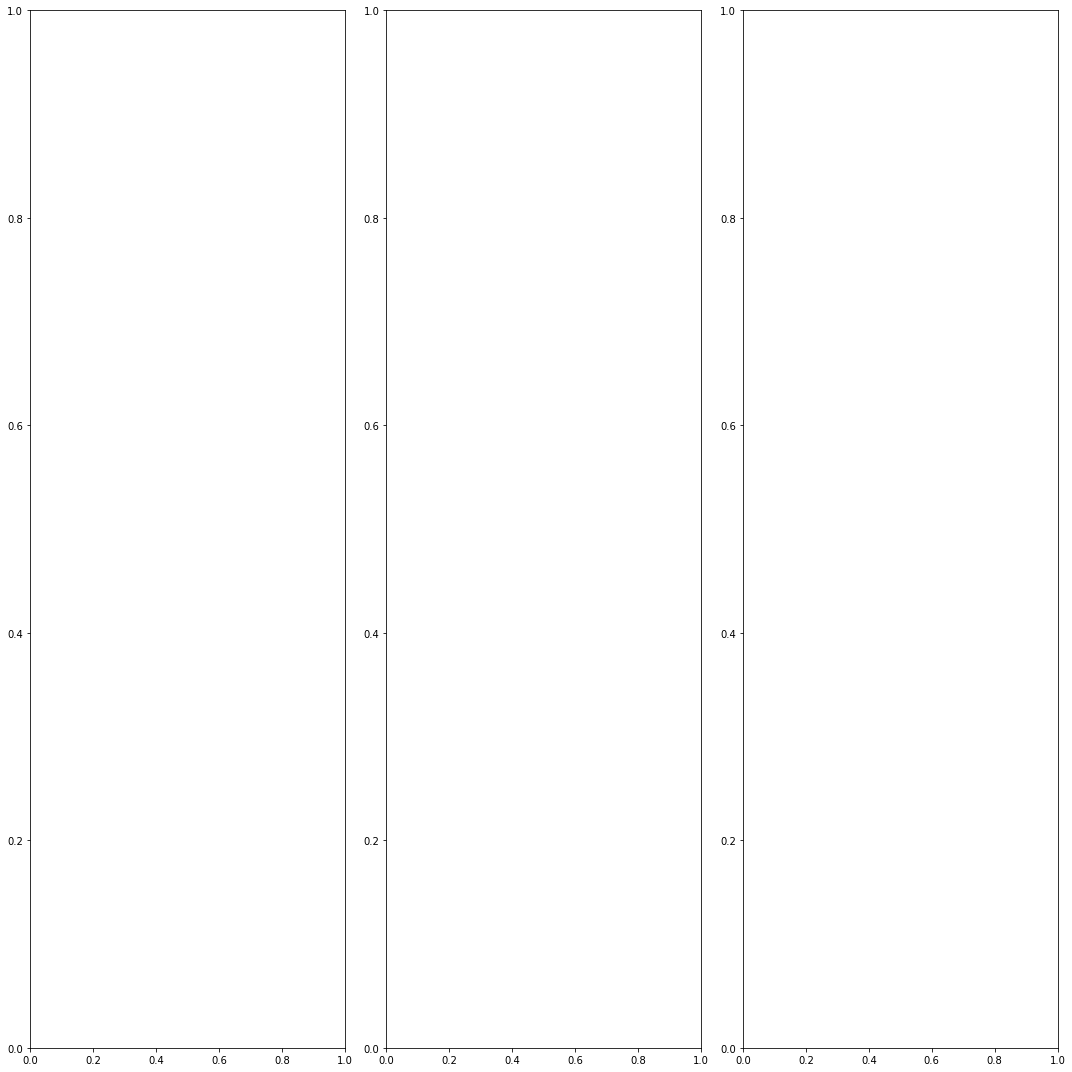

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
i = 1
# FIRST ROW: display image segment
for demo_img, n, ax in zip(demo_img_list, iter_num, ax_list):
    demo_img = (demo_img * 255).astype(np.uint8)
    ax.imshow(demo_img)
    ax.set_title('Image Segment by EM at Iteration {}'.format(n))
    # Set x-axis, y-axis
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1;

plt.tight_layout()
fig.savefig('EM_iterations.pdf')